# Test notebook for pastas with Pest Solver

## Packages

In [38]:
from pathlib import Path

import pandas as pd
import pastas as ps

import pastas_plugins.pest as psp

if "b" not in ps.__version__:
    # https://github.com/pastas/pastas/pull/796 is required
    raise Exception("Please run Pastas on the dev branch")

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
head = (
    pd.read_csv(
        "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",
        index_col="date",
        parse_dates=True,
    ).squeeze()
).iloc[-300:]
prec = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
evap = pd.read_csv(
    "https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv",
    index_col="date",
    parse_dates=True,
).squeeze()
pex = (prec - evap).dropna().rename("PrecipitationExcess")

## Create Model

In [3]:
ml = ps.Model(head, name="PestGLM")
sm = ps.StressModel(
    pex, ps.Exponential(), name="pex", settings=ps.rcParams["timeseries"]["evap"]
)

ml.add_stressmodel(sm)

## Solve with SciPy Least Squares

Fit report LeastSquares           Fit Statistics
nfev    24                     EVP         88.65
nobs    300                    R2           0.89
noise   False                  RMSE         0.13
tmin    2001-05-28 00:00:00    AICc     -1229.99
tmax    2015-06-28 00:00:00    BIC      -1218.96
freq    D                      Obj          2.44
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (3 optimized)
               optimal     initial  vary
pex_A       850.877884  215.674528  True
pex_a       177.192197   10.000000  True
constant_d   27.508810   27.902000  True


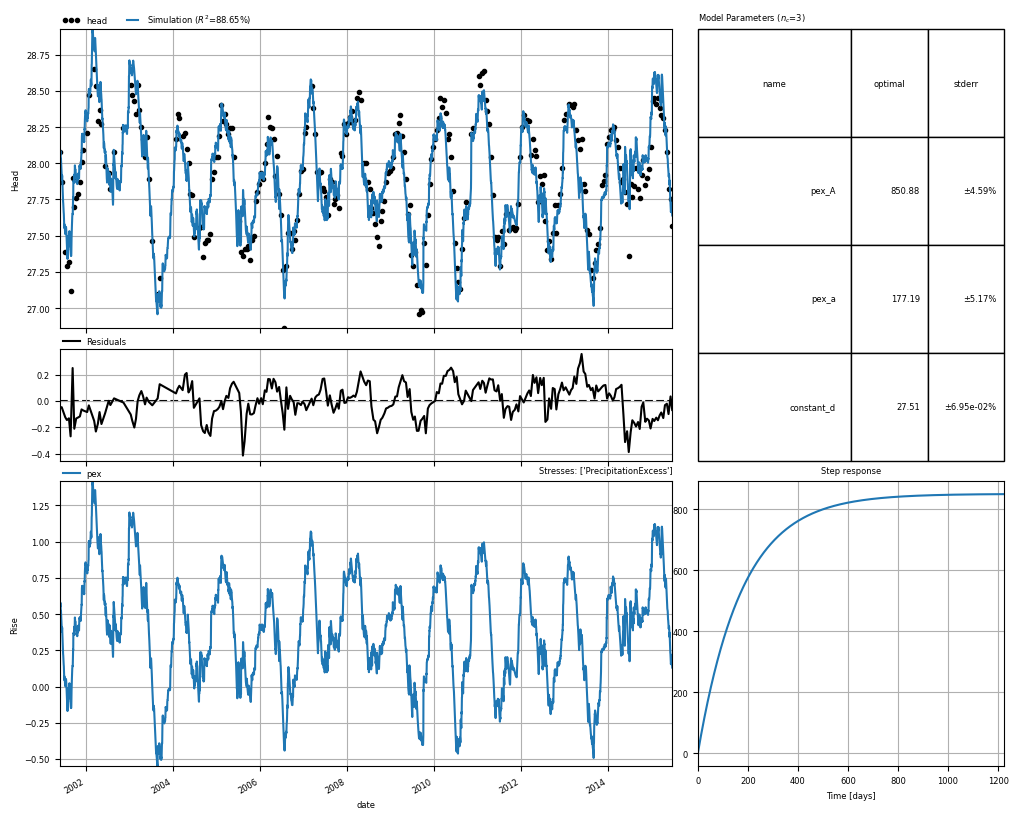

In [69]:
ml_ls = ml.copy()
ml_ls.name = "LeastSquares"
ml_ls.solve(solver=ps.LeastSquares())
_ = ml_ls.plots.results(stderr=True)

## Pest-IES

In [75]:
ml_ies = ml.copy()
solver = psp.PestIemSolver(
    exe_name="bin/pestpp-ies",
    model_ws=Path("pestf_ies/model"),
    temp_ws=Path("pestf_ies/temp"),
    master_ws=Path("pestf_ies/master"),
    noptmax=10,
)
ml_ies.solver = solver
ml_ies.solver.set_model(ml_ies)
ml_ies.solver.prior_monte_carlo(ies_num_reals=100)
# ml_ies.solve(solver=solver)

2024-08-09 16:55:06.250249 starting: opening PstFrom.log for logging
2024-08-09 16:55:06.251089 starting PstFrom process
2024-08-09 16:55:06.251260 starting: setting up dirs
2024-08-09 16:55:06.251378 starting: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-08-09 16:55:06.253349 finished: removing existing new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.001971
2024-08-09 16:55:06.253413 starting: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp'
2024-08-09 16:55:06.256249 finished: copying original_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/model' to new_d '/home/martin/pastas-plugins/docs/examples/pestf_ies/temp' took: 0:00:00.002836
2024-08-09 16:55:06.257443 finished: setting up dirs took: 0:00:00.006183
2024-08-09 16:55:06.286416 transform was not passed, setting default tranform to 'log'
2024-08-09 16:5

In [77]:
import pyemu
pst = pyemu.Pst(str(solver.temp_ws / "pest.pst"))

pr_oe = pyemu.ObservationEnsemble.from_csv(pst=pst, filename=solver.master_ws / "pest.0.obs.csv")
pt_oe = pyemu.ObservationEnsemble.from_csv(pst=pst, filename=solver.master_ws / f"pest.{pst.control_data.noptmax-1}.obs.csv")
noise = pyemu.ObservationEnsemble.from_csv(pst=pst, filename=solver.master_ws / "pest.obs+noise.csv")

return type uncaught, losing Ensemble type, returning DataFrame
return type uncaught, losing Ensemble type, returning DataFrame


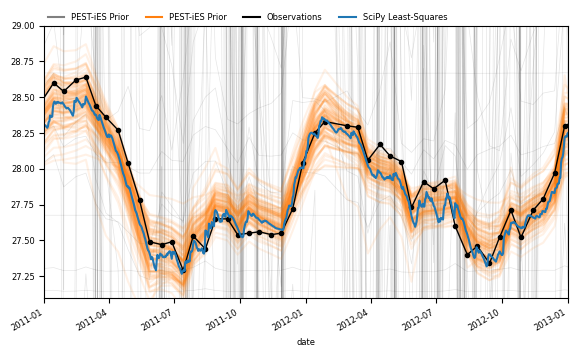

In [90]:
f, ax = plt.subplots(figsize=(6.75, 4))
pr_oe.transpose().set_index(ml.observations().index).plot(ax=ax, legend=False, linewidth=0.5, color="black", alpha=0.1)
pt_oe.transpose().set_index(ml.observations().index).plot(ax=ax, legend=False, color="C1", alpha=0.1)
ml.observations().plot(ax=ax, color="k", linewidth=1, marker=".")
ax.set_ylim(ml.observations().min(), ml.observations().max())
ax.set_xlim(pd.Timestamp('2011'), pd.Timestamp("2013"))
ax.plot([], [], color="grey", alpha=1.0, label="PEST-iES Prior")
ax.plot([], [], color="C1", alpha=1.0, label="PEST-iES Prior")
ax.plot([], [], color="k", alpha=1.0, label="Observations")
ml_ls.simulate().plot(ax=ax, color="C0", linestyle="-", label="SciPy Least-Squares")
ax.set_ylim(27.1, 29.0)
ax.grid(False)
labels, handles = ax.get_legend_handles_labels()
ax.legend(labels[-4:], handles[-4:], loc=(0,1), ncol=4, frameon=False)
f.savefig("pest-ies-obs-ensemble.png", dpi=300, bbox_inches="tight")

## Compare Results

### Plot

Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.


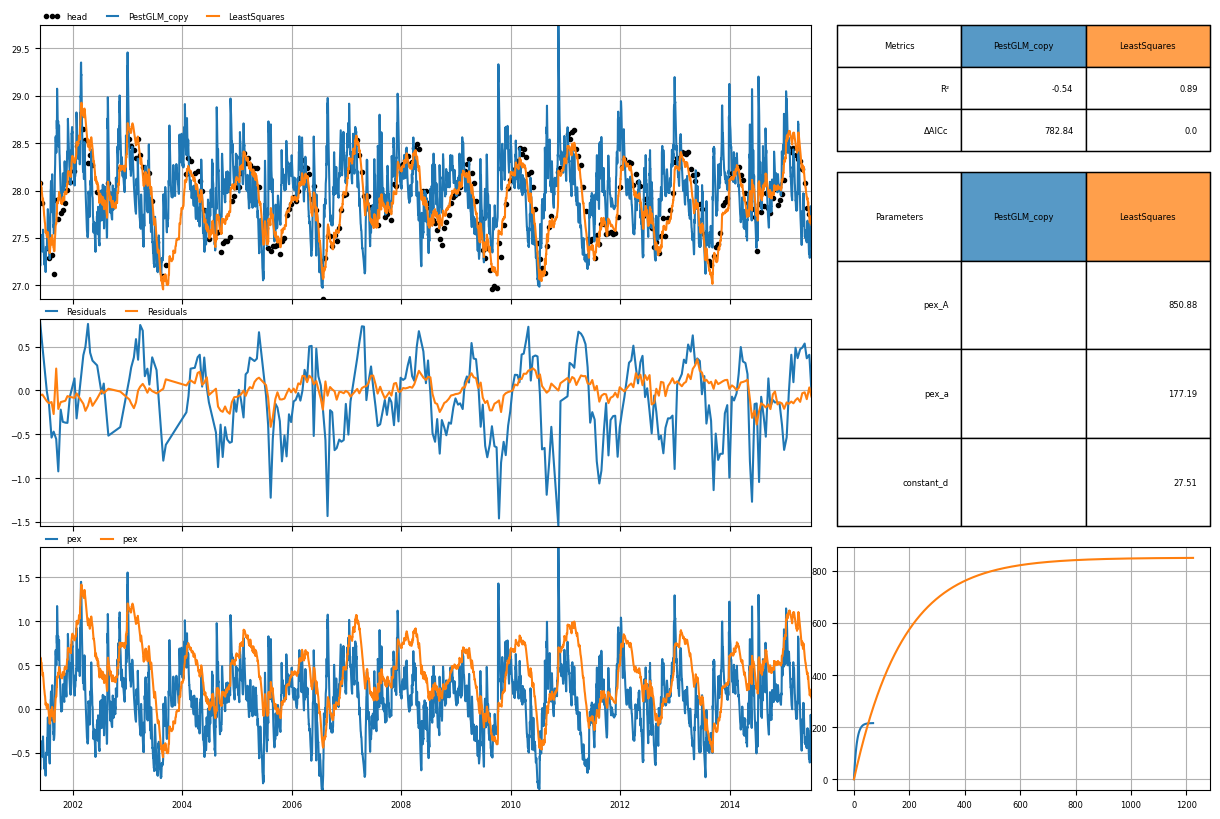

In [ ]:
ps.plots.compare([ml_ies, ml_ls], figsize=(12.0, 8.0));

### Fit metrics

In [ ]:
pd.concat(
    [ml_ies.stats.summary(), ml_ls.stats.summary()],
    axis=1,
    keys=[ml_ies.name, ml_ls.name],
).drop("rmsn")

Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.
Model is not optimized yet, initial parameters are used.


,PestGLM_copy,LeastSquares
,Value,Value
Statistic,,
rmse,0.469832,0.127439
sse,66.222689,4.872243
mae,0.383515,0.103322
nse,-0.543307,0.886453
evp,0.000000,88.645332
rsq,-0.543307,0.886453
kge,0.293639,0.916928
bic,-436.116453,-1218.957099


### Parameters (and stderr)

In [ ]:
pd.concat(
    [
        ml_ies.parameters.loc[:, ["optimal", "stderr"]],
        ml_ls.parameters.loc[:, ["optimal", "stderr"]],
    ],
    axis=1,
    keys=[ml_ies.name, ml_ls.name],
)

PestGLM_copy        LeastSquares           
                optimal stderr      optimal     stderr
pex_A               NaN    NaN   850.877884  39.066280
pex_a               NaN    NaN   177.192197   9.168912
constant_d          NaN    NaN    27.508810   0.019113

Standard error for the PestGlm optimization seems a bit too small. The PestHp does not have a standarderror, nor a covariance matrix (`pcov`). PestHp does have parameter sensitivy values but I'm not sure how to interpet those.

### Covariance matrices

In [ ]:
pd.concat(
    [ml_ies.solver.pcov, ml_ls.solver.pcov], axis=1, keys=[ml_ies.name, ml_ls.name]
)

LeastSquares                       
                  pex_A       pex_a constant_d
pex_A       1526.174231  319.413542  -0.688454
pex_a        319.413542   84.068950  -0.143182
constant_d    -0.688454   -0.143182   0.000365